In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [3]:
sr = 44100
input_length = int(sr/2)
batch_size = 32


def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=sr)[0] 
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

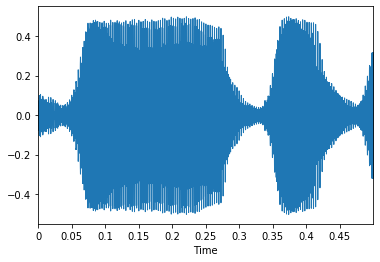

In [5]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=sr, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [6]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [7]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.sr = 44100
        self.input_length = int(sr/2)
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [8]:
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [9]:
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=32, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=32, shuffle=32)

# Model

In [19]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_256_3 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding=True)
        self.conv1d_256_256_3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_256_64 = nn.Linear(in_features=256, out_features=64)
        self.fc_64_1024 = nn.Linear(in_features=64, out_features=1024)
        self.fc_1024_42 = nn.Linear(in_features=1024, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_256_3(x)
        x = self.relu(x)
        x = self.conv1d_256_256_3(x)
        x = self.relu(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_256_64(x)
        x = self.relu(x)
        x = self.fc_64_1024(x)
        x = self.relu(x)
        x = self.fc_1024_42(x)
        x = self.softmax(x)
        
        return x

In [20]:
device

device(type='cuda')

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 22050))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 22044]             160
              ReLU-2            [-1, 16, 22044]               0
            Conv1d-3            [-1, 16, 22038]           2,320
              ReLU-4            [-1, 16, 22038]               0
         MaxPool1d-5             [-1, 16, 1377]               0
           Dropout-6             [-1, 16, 1377]               0
            Conv1d-7             [-1, 32, 1377]           1,568
              ReLU-8             [-1, 32, 1377]               0
            Conv1d-9             [-1, 32, 1377]           3,104
             ReLU-10             [-1, 32, 1377]               0
        MaxPool1d-11              [-1, 32, 344]               0
          Dropout-12              [-1, 32, 344]               0
           Conv1d-13              [-1, 32, 344]           3,104
             ReLU-14              [-1, 

In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)

FreeSound_Sense(
  (conv1d_1_16_9): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_16_9): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_32_3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_32_3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_256_3): Conv1d(32, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_256_256_3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (maxpool_16): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigm): Sigmoid()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_256_64): Linear(in_features=256, out_features=64, bias=True)
  (fc_64_1024): Linear(in_features=64, out_features=1024, bias=True)
  (fc_1024_42): Linear(in_features=1024, out_features=

In [23]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
epoch_progress_bar = tqdm.tqdm(range(0, 1000))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*32)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*32)))


Epoch Loss:  3.6390429347879274
Train Acc  13.83175105485232



Valid Acc  15.208333333333334



Epoch Loss:  3.6326879609989216
Train Acc  14.464662447257384



Valid Acc  14.6875



Epoch Loss:  3.6360850525304738
Train Acc  14.17457805907173



Valid Acc  11.71875



Epoch Loss:  3.636405737591192
Train Acc  13.897679324894515



Valid Acc  13.90625



Epoch Loss:  3.635599758051619
Train Acc  14.253691983122362



Valid Acc  14.479166666666666



Epoch Loss:  3.6323725955898754
Train Acc  14.662447257383967



Valid Acc  14.375



Epoch Loss:  3.6315955562430595
Train Acc  14.51740506329114



Valid Acc  14.0625



Epoch Loss:  3.6325515141467
Train Acc  14.596518987341772



Valid Acc  14.53125



Epoch Loss:  3.629689016422642
Train Acc  14.794303797468354



Valid Acc  15.260416666666666



Epoch Loss:  3.6454135798200777
Train Acc  13.27795358649789



Valid Acc  13.28125



Epoch Loss:  3.636725312043846
Train Acc  14.003164556962025



Valid Acc  14.010416666666666



Epoch Loss:  3.6307013940207566
Train Acc  14.649261603375528



Valid Acc  14.375



Epoch Loss:  3.637034801491202
Train Acc  14.082278481012658



Valid Acc  15.104166666666666



Epoch Loss:  3.629488384673364
Train Acc  14.833860759493671



Valid Acc  14.427083333333334



Epoch Loss:  3.63114619456263
Train Acc  14.477848101265822



Valid Acc  15.3125



Epoch Loss:  3.6324636724930777
Train Acc  14.49103375527426



Valid Acc  14.166666666666666



Epoch Loss:  3.632601225929421
Train Acc  14.438291139240507



Valid Acc  14.479166666666666



Epoch Loss:  3.627578412430196
Train Acc  15.123945147679326



Valid Acc  14.427083333333334



Epoch Loss:  3.6260108716377224
Train Acc  15.097573839662447



Valid Acc  14.583333333333334



Epoch Loss:  3.6279637481592877
Train Acc  14.939345991561181



Valid Acc  13.645833333333334



Epoch Loss:  3.6314190258959678
Train Acc  14.39873417721519



Valid Acc  14.427083333333334



Epoch Loss:  3.6303310635723647
Train Acc  14.570147679324894



Valid Acc  14.114583333333334



Epoch Loss:  3.6280016235158414
Train Acc  14.912974683544304



Valid Acc  14.84375



Epoch Loss:  3.6300986074697117
Train Acc  14.794303797468354



Valid Acc  14.375



Epoch Loss:  3.626846449284614
Train Acc  15.17668776371308



Valid Acc  15.416666666666666



Epoch Loss:  3.6281331611585013
Train Acc  14.939345991561181



Valid Acc  15.208333333333334



Epoch Loss:  3.6307106319862075
Train Acc  14.570147679324894



Valid Acc  15.104166666666666



Epoch Loss:  3.6301514398196577
Train Acc  14.662447257383967



Valid Acc  15.46875



Epoch Loss:  3.6314173207504337
Train Acc  14.636075949367088



Valid Acc  14.895833333333334



Epoch Loss:  3.630473631846754
Train Acc  14.51740506329114



Valid Acc  14.375



Epoch Loss:  3.6282277167597905
Train Acc  14.662447257383967



Valid Acc  14.0625



Epoch Loss:  3.6346731206032796
Train Acc  14.29324894514768



Valid Acc  14.21875



Epoch Loss:  3.6268850147472653
Train Acc  15.018459915611814



Valid Acc  13.541666666666666



Epoch Loss:  3.6251773965006637
Train Acc  15.282172995780591



Valid Acc  14.114583333333334



Epoch Loss:  3.6276920012783904
Train Acc  14.95253164556962



Valid Acc  13.541666666666666



Epoch Loss:  3.630589225624181
Train Acc  14.702004219409282



Valid Acc  14.21875



Epoch Loss:  3.632018134563784
Train Acc  14.51740506329114



Valid Acc  15.208333333333334


In [25]:
torch.save(Model.state_dict(), "FreeSound_1D_conv_global_pool_1100_epoch.stDict")

In [154]:
i=0
for data in FreeSoundDataLoader:
    if i==6:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.125 4


[(tensor(30), False),
 (tensor(20), False),
 (tensor(8), False),
 (tensor(25), False),
 (tensor(15), True),
 (tensor(28), False),
 (tensor(18), False),
 (tensor(33), False),
 (tensor(36), False),
 (tensor(23), False),
 (tensor(13), False),
 (tensor(21), False),
 (tensor(4), False),
 (tensor(9), False),
 (tensor(20), False),
 (tensor(10), False),
 (tensor(29), False),
 (tensor(37), False),
 (tensor(35), False),
 (tensor(1), False),
 (tensor(15), True),
 (tensor(26), True),
 (tensor(25), True),
 (tensor(2), False),
 (tensor(30), False),
 (tensor(38), False),
 (tensor(27), False),
 (tensor(14), False),
 (tensor(18), False),
 (tensor(7), False),
 (tensor(26), False),
 (tensor(17), False)]